In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score  # Import accuracy metric

In [72]:
#reading data
data = pd.read_csv("diabetic_data.csv", delimiter=',')
customers_data=data.copy()
customers_data.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [73]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [74]:
customers_data.isin(['?']).sum()
customers_data.replace('?',np.NaN,inplace =True)

In [75]:
## dropping encounter id and patient id as these used to identify and does not effect the classification 
customers_data=customers_data.drop(columns='encounter_id')
customers_data=customers_data.drop(columns='patient_nbr')
## dropping weight as it has 97% missing data mentioned in data description
customers_data=customers_data.drop(columns='weight')
##dropping payer code as how payment is made does not effect health
customers_data=customers_data.drop(columns='payer_code')
##Removing medical specialty as high number of null values
customers_data=customers_data.drop(columns='medical_specialty')



In [76]:
## dropping ? mark value and unknown value
drop_Idx = set(customers_data[(customers_data['diag_1'] == '?') & (customers_data['diag_2'] == '?') & (customers_data['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(customers_data['diag_1'][customers_data['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(customers_data['diag_2'][customers_data['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(customers_data['diag_3'][customers_data['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(customers_data['race'][customers_data['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(customers_data[customers_data['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(customers_data['gender'][customers_data['gender'] == 'Unknown/Invalid'].index))

new_Idx = list(set(customers_data.index) - set(drop_Idx))
customers_data = customers_data.iloc[new_Idx]


In [77]:
customers_data["readmitted"].value_counts()


readmitted
NO     53219
>30    35545
<30    11357
Name: count, dtype: int64

In [78]:
customers_data["examide"].value_counts()


examide
No    100121
Name: count, dtype: int64

In [79]:
customers_data["citoglipton"].value_counts()


citoglipton
No    100121
Name: count, dtype: int64

In [80]:
customers_data=customers_data.drop(columns='examide')
customers_data=customers_data.drop(columns='citoglipton')
#dropping these 2 attributes as both have same value for each row which is 'NO'


In [81]:
#Checking for missing values in the data
for col in customers_data.columns:
    if customers_data[col].dtype == object:
         print(col,customers_data[col][customers_data[col] == '?'].count())
            
print('gender', customers_data['gender'][customers_data['gender'] == 'Unknown/Invalid'].count())

race 0
gender 0
age 0
diag_1 0
diag_2 0
diag_3 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 0


In [82]:
#converting readmitted into binary 
customers_data['readmitted'] = customers_data['readmitted'].map({'NO': 0, '<30': 1, ">30":2})
customers_data['readmittedbinary'] = customers_data['readmitted'].map({0: 0, 1: 1, 2:1})

In [83]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100121 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      97884 non-null   object
 1   gender                    100121 non-null  object
 2   age                       100121 non-null  object
 3   admission_type_id         100121 non-null  int64 
 4   discharge_disposition_id  100121 non-null  int64 
 5   admission_source_id       100121 non-null  int64 
 6   time_in_hospital          100121 non-null  int64 
 7   num_lab_procedures        100121 non-null  int64 
 8   num_procedures            100121 non-null  int64 
 9   num_medications           100121 non-null  int64 
 10  number_outpatient         100121 non-null  int64 
 11  number_emergency          100121 non-null  int64 
 12  number_inpatient          100121 non-null  int64 
 13  diag_1                    100100 non-null  object
 14  diag_2   

In [84]:
# code age intervals [0-10) - [90-100) from 1-10 we take average of age range
for i in range(0,10):
    customers_data['age'] = customers_data['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
customers_data['age'].value_counts()

age
8     25564
7     22187
6     17102
9     16708
5      9626
4      3765
10     2669
3      1650
2       690
1       160
Name: count, dtype: int64

In [85]:
customers_data.isin([np.NaN]).sum()
customers_data.isnull().sum()
customers_data.dropna(how='any',inplace=True)




In [86]:
print(customers_data.duplicated().value_counts()) ##checking for duplicated data
customers_data=customers_data.drop_duplicates() # dropping duplicated data
print(customers_data.duplicated().value_counts())

False    286
Name: count, dtype: int64
False    286
Name: count, dtype: int64


In [87]:
def change_string_to_int(column):
    variables=pd.unique(customers_data[column])
    for item in range(variables.size):
        customers_data[column]=[item if each==variables[item] else each for each in customers_data[column]]
    return customers_data[column]

In [88]:
customers_data["gender"]=change_string_to_int("gender")


In [89]:
customers_data["gender"].value_counts()


gender
1    166
0    120
Name: count, dtype: int64

In [90]:
customers_data["race"].value_counts()


race
Caucasian          177
AfricanAmerican     51
Hispanic            38
Other               13
Asian                7
Name: count, dtype: int64

In [91]:
customers_data["race"]=change_string_to_int("race")


In [92]:
customers_data["diag_1"]=change_string_to_int("diag_1")
customers_data["diag_2"]=change_string_to_int("diag_2")
customers_data["diag_3"]=change_string_to_int("diag_3")


In [93]:
customers_data["max_glu_serum"].value_counts()


max_glu_serum
>300    121
Norm     96
>200     69
Name: count, dtype: int64

In [94]:
#since max glu serum and A1C has alot of None values,  which indicates not measured we put it into categories of Normal Abnormal and Not tested
customers_data['A1Cresult'] = customers_data['A1Cresult'].replace('>7', 1)
customers_data['A1Cresult'] = customers_data['A1Cresult'].replace('>8', 1)
customers_data['A1Cresult'] = customers_data['A1Cresult'].replace('Norm', 0)
#customers_data['A1Cresult'] = customers_data['A1Cresult'].replace('nan', -99)
customers_data['A1Cresult'] = customers_data['A1Cresult'].replace(np.nan, -99)

customers_data['max_glu_serum'] = customers_data['max_glu_serum'].replace('>200', 1)
customers_data['max_glu_serum'] = customers_data['max_glu_serum'].replace('>300', 1)
customers_data['max_glu_serum'] = customers_data['max_glu_serum'].replace('Norm', 0)
#customers_data['max_glu_serum'] = customers_data['max_glu_serum'].replace('nan', -99)
customers_data['max_glu_serum'] = customers_data['max_glu_serum'].replace(np.nan, -99)


In [95]:
customers_data["max_glu_serum"].value_counts()


max_glu_serum
1    190
0     96
Name: count, dtype: int64

In [96]:
customers_data["max_glu_serum"].value_counts()


max_glu_serum
1    190
0     96
Name: count, dtype: int64

In [97]:
for col in customers_data:
    print(f"{col} = {customers_data[col].unique()}")

race = [0 1 2 3 4]
gender = [0 1]
age = [9 8 6 4 5 7 2 3]
admission_type_id = [6 1 2 3]
discharge_disposition_id = [ 3  1  6 10  2  7  5 13]
admission_source_id = [7 2 1]
time_in_hospital = [ 5 10  2 11 14  7  3  4 13  6  1  9  8 12]
num_lab_procedures = [ 47  72  61  71  43 105  66  76  41  58  69  52  64  60  77  55  95  67
  74  65  53  45  68  81  83  78  98  62  54  75  63  87  56  96  79  49
  94  57  84  80  59  38  82  91  46  50  51  73  48  44  85  70  36  93
  39  32  42  40  88  31 106  97  90]
num_procedures = [1 0 3 2 6 5 4]
num_medications = [ 6 19  5 20 11 16  3  9 13  8 17 28 10 14 15 12 26 21  4 22 18  1 30  7
  2 23 25 35 27 32 34 24 33 31 29]
number_outpatient = [0 1 3 2 5 6]
number_emergency = [0 1 2 9 6 7 3 5]
number_inpatient = [0 1 3 2 6 4 5 7 9]
diag_1 = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 

In [98]:
for col in customers_data.columns[19:42]:
    if customers_data[col].dtype!='int64' and customers_data[col].dtype!= 'float64':
        
        customers_data[col]=change_string_to_int(col)

In [99]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 162 to 101088
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   race                      286 non-null    int64
 1   gender                    286 non-null    int64
 2   age                       286 non-null    int64
 3   admission_type_id         286 non-null    int64
 4   discharge_disposition_id  286 non-null    int64
 5   admission_source_id       286 non-null    int64
 6   time_in_hospital          286 non-null    int64
 7   num_lab_procedures        286 non-null    int64
 8   num_procedures            286 non-null    int64
 9   num_medications           286 non-null    int64
 10  number_outpatient         286 non-null    int64
 11  number_emergency          286 non-null    int64
 12  number_inpatient          286 non-null    int64
 13  diag_1                    286 non-null    int64
 14  diag_2                    286 non-null    

In [100]:
random_seed=42
data_copy_sample=customers_data.copy() #Using all the dataa

In [101]:
X=data_copy_sample.drop(columns=['readmittedbinary'],axis=1) #dropping class 
y=data_copy_sample['readmittedbinary']
X.head()


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
162,0,0,9,6,3,7,5,47,1,6,...,0,0,0,0,0,0,0,0,0,1
460,1,1,8,6,1,7,10,72,1,19,...,0,1,0,0,0,0,0,1,1,2
593,0,1,6,6,1,7,2,61,0,5,...,0,2,0,0,0,0,0,0,1,0
696,2,0,8,6,6,7,11,71,1,20,...,0,0,0,0,0,0,0,0,1,0
771,0,1,4,6,1,2,14,43,0,11,...,0,0,0,0,0,0,0,0,0,2


In [102]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [103]:
#splitting the data into 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)


In [104]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)  # Added DT
}


In [105]:
k_values = range(3, 21)
# Dictionary to store results
results = []

In [106]:
# Perform cross-validation for each K value
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Shuffle to reduce order bias

    for model_name, model in models.items():
        # Compute cross-validation scores
        model.fit(X_train, y_train)

        # Predict on test data
        y_pred = model.predict(X_test)

        # Compute test accuracy
        test_accuracy = accuracy_score(y_test, y_pred)

        # Compute variance using cross-validation on training data
        train_accuracies = cross_val_score(model, X_train, y_train, cv=kf)
        train_accuracy_mean = np.mean(train_accuracies)  # Training accuracy
        train_accuracy_variance = np.var(train_accuracies)  # Training accuracy variance


        # Compute bias using test set (1 - Accuracy)
        ##bias = 1 - accuracy

        bias = train_accuracy_mean - test_accuracy

        results.append({
            "Model": model_name,
            "K": k,
            "Training Accuracy": train_accuracy_mean,
            "Variance": train_accuracy_variance,
            "Test Accuracy": test_accuracy,
            "Bias": bias
        })

        


In [107]:
# Convert results into a DataFrame
import pandas as pd
df_results = pd.DataFrame(results)

# Save results to a CSV file
df_results.to_csv("bias_variance_results.csv", index=False)

# Display results without ace_tools
print(df_results.head())  # Print first 5 rows for verification

                    Model  K  Training Accuracy  Variance  Test Accuracy  \
0     Logistic Regression  3           0.954922  0.000455       1.000000   
1     K-Nearest Neighbors  3           0.809815  0.000725       0.790698   
2  Support Vector Machine  3           0.944746  0.001885       0.976744   
3           Decision Tree  3           1.000000  0.000000       1.000000   
4     Logistic Regression  4           0.965000  0.000475       1.000000   

       Bias  
0 -0.045078  
1  0.019117  
2 -0.031998  
3  0.000000  
4 -0.035000  


In [108]:
df_check = pd.read_csv("bias_variance_results.csv")
print(df_check.head())  # Print first few rows

                    Model  K  Training Accuracy  Variance  Test Accuracy  \
0     Logistic Regression  3           0.954922  0.000455       1.000000   
1     K-Nearest Neighbors  3           0.809815  0.000725       0.790698   
2  Support Vector Machine  3           0.944746  0.001885       0.976744   
3           Decision Tree  3           1.000000  0.000000       1.000000   
4     Logistic Regression  4           0.965000  0.000475       1.000000   

       Bias  
0 -0.045078  
1  0.019117  
2 -0.031998  
3  0.000000  
4 -0.035000  


In [109]:
# Function to plot Bias vs K and Variance vs K for each model
def plot_results(df, metric, ylabel, title_suffix):
    for model_name in df["Model"].unique():
        plt.figure(figsize=(8, 5))

        # Filter data for a specific model
        model_data = df[df["Model"] == model_name]
        x = model_data["K"].values
        y = model_data[metric].values

        # Scatter plot (Black markers)
        plt.scatter(x, y, color="black", label=f"{model_name} {ylabel}")

        # Fit and plot a straight trend line (Linear regression of degree 1)
        z = np.polyfit(x, y, 1)  # Linear trend line
        p = np.poly1d(z)
        plt.plot(x, p(x), color="black")  # Solid black trend line
        
        # Labels and title
        plt.xlabel("K Value")
        plt.ylabel(ylabel)
        plt.title(f"{ylabel} vs K Value ({model_name})")
        plt.legend()
        plt.grid(color='gray', linestyle='solid', linewidth=0.5)
        plt.show()

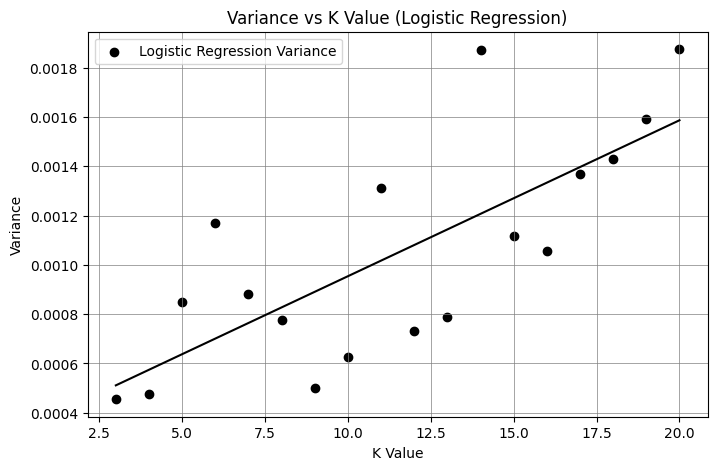

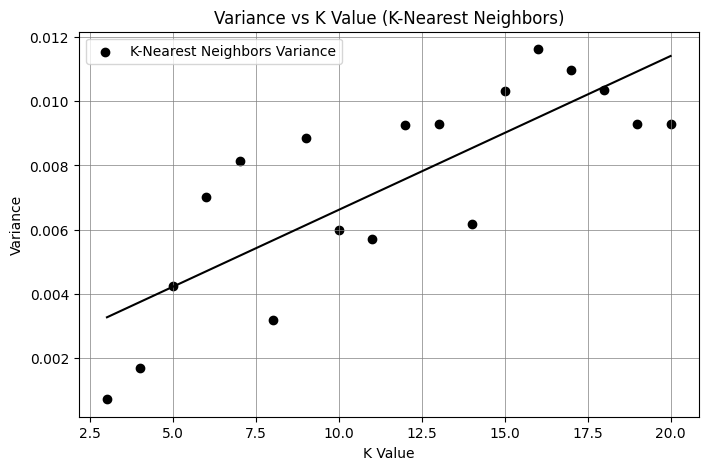

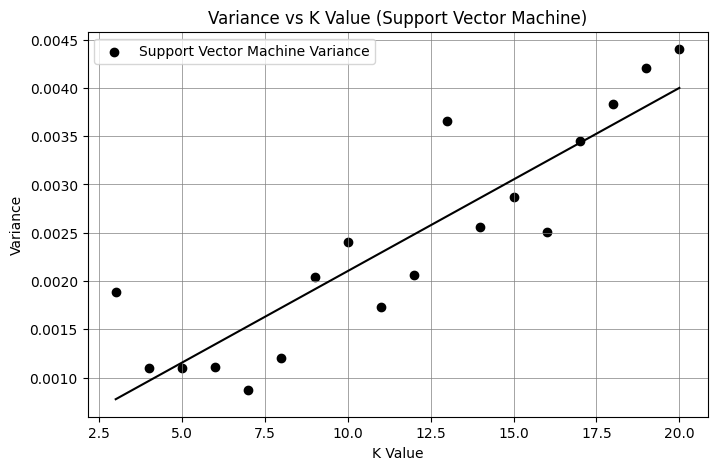

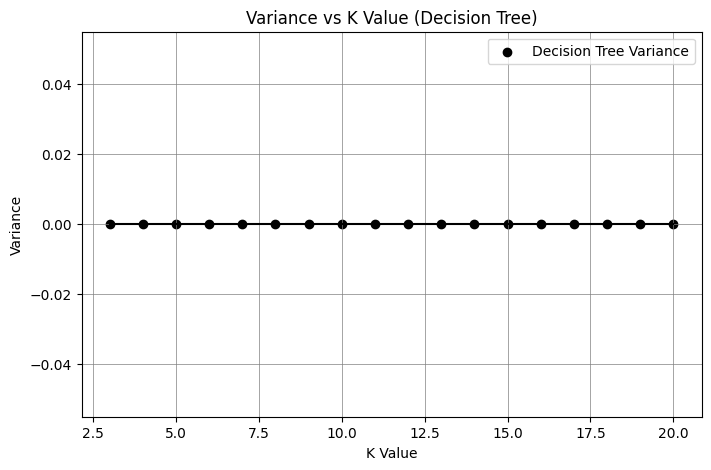

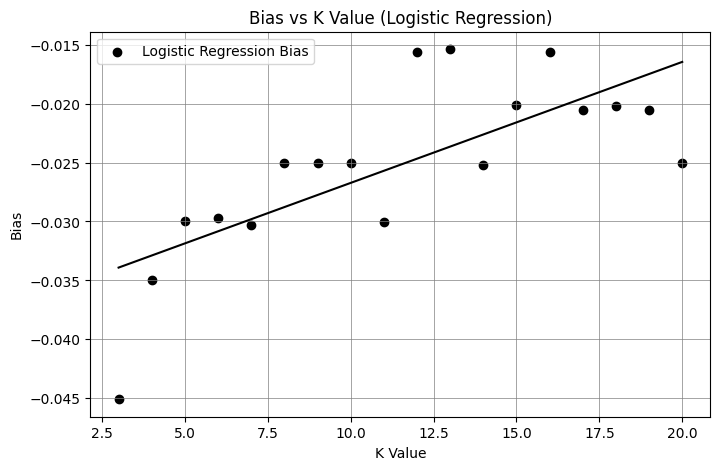

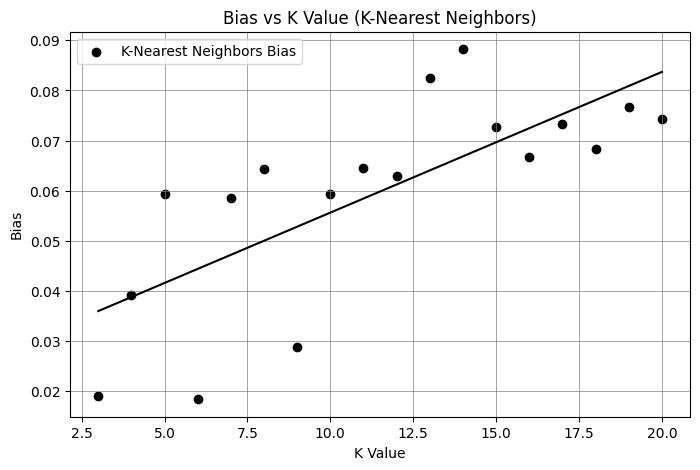

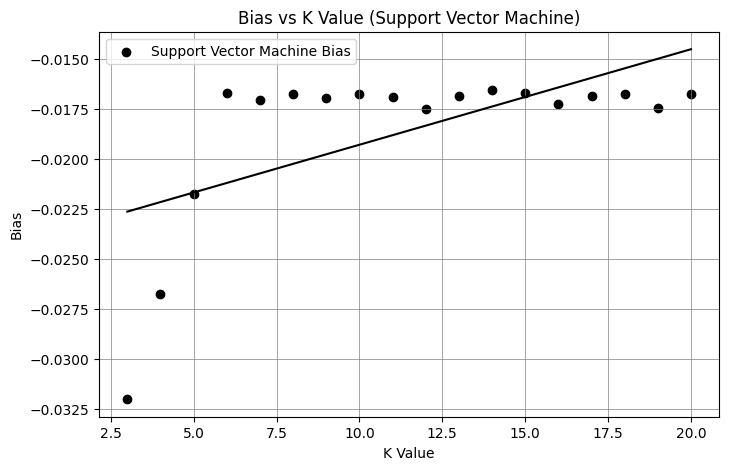

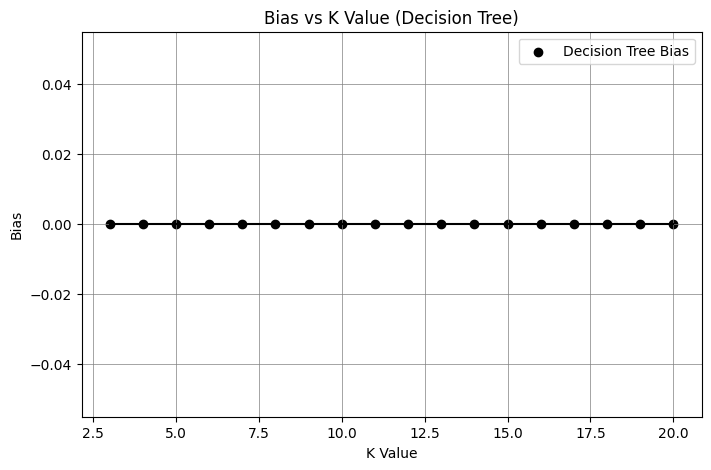

In [110]:
# Generate plots only for Bias and Variance
plot_results(df_results, "Variance", "Variance", "Effect of K on Variance")
plot_results(df_results, "Bias", "Bias", "Effect of K on Bias (Train Accuracy - Test Accuracy)")

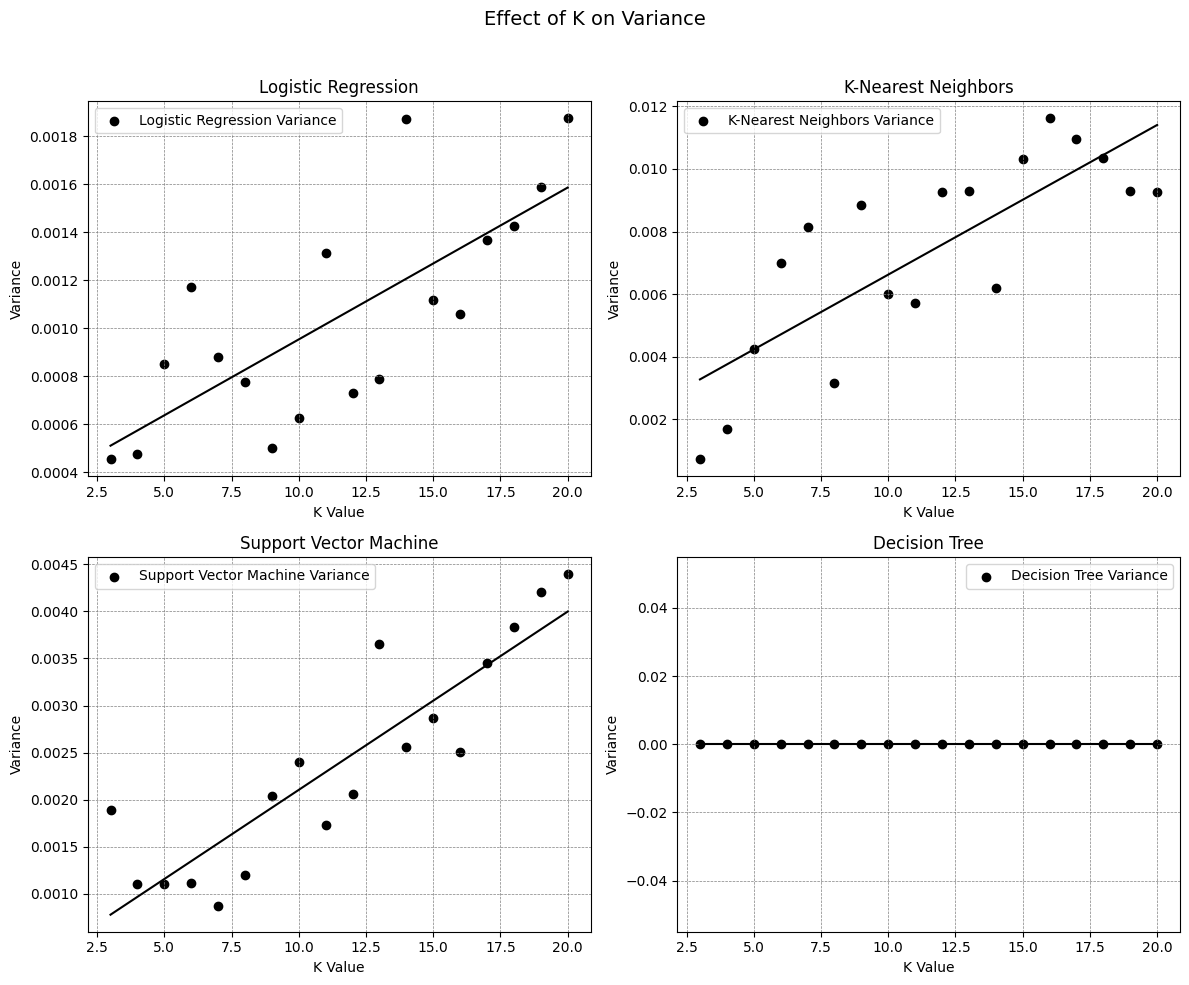

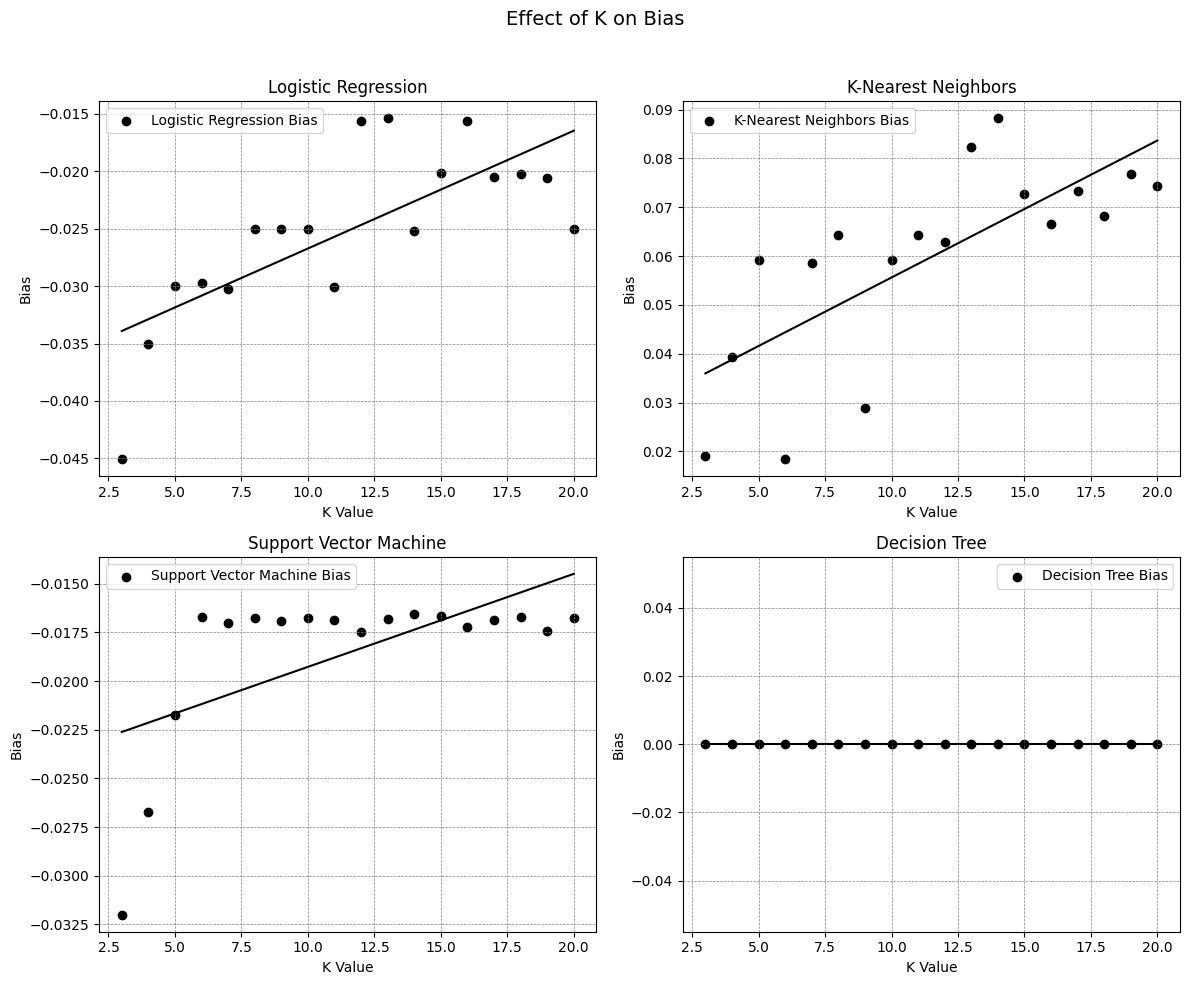

In [111]:
# Function to plot grouped Bias and Variance graphs (4 per image)
def plot_grouped_results(df, metric, ylabel, title_suffix, filename):
    models_list = df["Model"].unique()  # Get unique model names
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create 2x2 subplot grid

    for i, model_name in enumerate(models_list[:4]):  # Limit to 4 models
        ax = axes[i // 2, i % 2]  # Position in 2x2 grid

        # Filter data for a specific model
        model_data = df[df["Model"] == model_name]
        x = model_data["K"].values
        y = model_data[metric].values

        # Scatter plot (Black markers)
        ax.scatter(x, y, color="black", label=f"{model_name} {ylabel}")

        # Fit and plot a straight trend line (Linear regression of degree 1)
        z = np.polyfit(x, y, 1)  # Linear trend line
        p = np.poly1d(z)
        ax.plot(x, p(x), color="black")  # Solid black trend line

        # Labels and title
        ax.set_xlabel("K Value")
        ax.set_ylabel(ylabel)
        ax.set_title(f"{model_name}")

        ax.legend()
        ax.grid(color='gray', linestyle='--', linewidth=0.5)

    # Adjust layout and show plot
    plt.suptitle(title_suffix, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save image
    plt.show()

# Generate grouped plots for Bias and Variance (Each containing 4 graphs)
plot_grouped_results(df_results, "Variance", "Variance", "Effect of K on Variance", "variance_graph.png")
plot_grouped_results(df_results, "Bias", "Bias", "Effect of K on Bias", "bias_graphs.png")
